In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import torch.nn.functional as F

In [2]:
class ArithmeticExpressionDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [10]:
class HelperClass:
    def __init__(self,X,Y,model,epochs,lr=1e-3):
        self.model=model
        self.epochs=epochs
        self.optimizer=optim.Adam(self.model.parameters(), lr=lr)
        self.X=X
        self.Y=Y
        self.criterion=nn.MSELoss()
    
    @staticmethod
    def init_device():
        device = torch.device('mps' if torch.backends.mps.is_available() else 'mps')
        torch.manual_seed(1)
        return device
    
    @staticmethod
    def plot_loss(train_loss, val_loss, epochs):
        plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
        plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    def dataloader(self,X,Y,batch_size=1024):
        #X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2)
        dataset = ArithmeticExpressionDataset(X,Y)
        dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return dataloader

    def saver(self,best_weights,PATH="./models"):
        name=''.join(f"{key}{val}" for key, val in self.model.__repr__().items())
        path=PATH+"/"+name
        torch.save(best_weights,path)

    def trainer(self):
        device=self.init_device()
        val_loss_list=[]
        train_loss_list=[]
        X_train, X_val, Y_train, Y_val = train_test_split(self.X, self.Y, test_size=0.2)
        train_loader=self.dataloader(X_train,Y_train)
        val_loader=self.dataloader(X_val,Y_val)
        best_valid_loss = float("inf")
        for epoch in range(self.epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.model.train()
            for x, y in train_loader:
                x = x.to(device)
                y = y.to(device)
                self.optimizer.zero_grad()
                output = self.model(x)
                loss = self.criterion(output, y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * x.size(0)
            train_loss /= len(train_loader.dataset)
            train_loss_list.append(train_loss)
            self.model.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(device)
                    y = y.to(device)
                    output = self.model(x)
                    loss = self.criterion(output, y)
                    val_loss += loss.item() * x.size(0)
                val_loss /= len(val_loader.dataset)
                val_loss_list.append(val_loss)
                if val_loss < best_valid_loss:
                    best_valid_loss=val_loss
                    best_weights = copy.deepcopy(self.model.state_dict())
            print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, self.epochs, train_loss, val_loss))
        self.plot_loss(train_loss_list,val_loss_list,self.epochs)
        self.saver(best_weights)
        return best_valid_loss
    
    def tester(self,X,Y):
        device=self.init_device()
        name=''.join(f"{key}{val}" for key, val in self.model.__repr__().items())
        path="./models/"+name
        self.model.load_state_dict(torch.load(path))
        test_loader=self.dataloader(X,Y)
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                output = self.model(x)
                loss = self.criterion(output, y)
                test_loss += loss.item()*x.size(0)
            test_loss /= len(test_loader.dataset)
            print('Test Loss: {:.6f}'.format(test_loss))
        return test_loss

In [4]:
class RNNModel(nn.Module):
    def __repr__(self):
        return {"model":"RNN","ES":self.embedding_size,"HS":self.hidden_size}
    
    def __init__(self, input_size, hidden_size, output_size, num_layers, embedding_size):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.embedding_size = embedding_size
        #Model Arch
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True,nonlinearity="relu")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])

        return out


In [5]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.manual_seed(1)
print(device)

mps


In [6]:
data = np.load("./data/ae_data.npz")

Str = data["Str"]
Xtr = torch.from_numpy(data["Xtr"]).type(torch.int)
Ytr = torch.from_numpy(data["Ytr"]).type(torch.float)

Ste = data["Ste"]
Xte = torch.from_numpy(data["Xte"]).type(torch.int)
Yte = torch.from_numpy(data["Yte"]).type(torch.float)

In [104]:
num_epochs = 2
batch_size = 1024
learning_rate = 1e-4
hidden_size = 64
num_layers = 4
embedding_size=16
model = RNNModel(input_size=13, hidden_size=hidden_size, num_layers=num_layers, output_size=1,embedding_size=embedding_size).to(device)

In [105]:
rnn=HelperClass(Xtr,Ytr,model,num_epochs,device)

In [106]:
class TransformerModel(nn.Module):
    def __repr__(self):
        return {"model":"Transformer","DM":self.d_model,"NH":self.nhead,"NL":self.num_layers}
    
    
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.d_model=d_model
        self.nhead=nhead
        self.num_layers=num_layers

        # Embedding layer
        self.embedding = nn.Embedding(input_dim, d_model)

        # Transformer model
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers)

        # Linear output layer
        self.output = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # Prepare the input tensor for the transformer model
        x = self.embedding(x)
        x = x.permute(1, 0, 2)

        # Forward propagate transformer model
        out = self.transformer(x, x)

        # Decode the output of the transformer model
        out = self.output(out[-1, :, :])

        return out

In [107]:
output_vocab_size=1
num_features=13
d_model=64
nhead=4
num_layers=4
model = TransformerModel(num_features,d_model,nhead,num_layers,output_vocab_size).to(device)

In [108]:
trans=HelperClass(Xtr,Ytr,model,num_epochs,device)

In [125]:
class MLPModel(nn.Module):
    def __repr__(self):
        return {"model":"MLP","FL":self.input_dim,"HL":self.hidden_dim}
    
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(MLPModel, self).__init__()
        self.input_dim = input_dimension
        self.hidden_dim = hidden_dimension
        self.output_dim = output_dimension
        self.layers=nn.Sequential(
            nn.Linear(input_dimension, hidden_dimension),
            nn.ReLU(),
            nn.Linear(hidden_dimension, hidden_dimension),
            nn.ReLU(),
            nn.Linear(hidden_dimension, output_dimension)
        )

    def forward(self, x):
        x=x.to(torch.float32)
        x = self.layers(x)
        return x

In [126]:
model = MLPModel(7, 512, 1).to(torch.device("mps"))

In [127]:
mlp=HelperClass(Xtr,Ytr,model,1000,torch.device("cpu"))

Epoch [1/1000], Train Loss: 175367.1403, Val Loss: 147450.6169
Epoch [2/1000], Train Loss: 128124.7341, Val Loss: 120034.8819
Epoch [3/1000], Train Loss: 113241.4988, Val Loss: 114014.2295
Epoch [4/1000], Train Loss: 109870.1180, Val Loss: 111857.8111
Epoch [5/1000], Train Loss: 107892.0471, Val Loss: 109866.1818
Epoch [6/1000], Train Loss: 106462.4312, Val Loss: 109387.2518
Epoch [7/1000], Train Loss: 105335.0437, Val Loss: 107388.5142
Epoch [8/1000], Train Loss: 104112.9704, Val Loss: 106406.4295
Epoch [9/1000], Train Loss: 102933.0935, Val Loss: 105067.3419
Epoch [10/1000], Train Loss: 101829.8720, Val Loss: 104580.5915
Epoch [11/1000], Train Loss: 100670.2126, Val Loss: 102764.6740
Epoch [12/1000], Train Loss: 99282.4828, Val Loss: 102078.3423
Epoch [13/1000], Train Loss: 97692.6617, Val Loss: 99994.7327
Epoch [14/1000], Train Loss: 96150.9796, Val Loss: 98667.3356
Epoch [15/1000], Train Loss: 94672.6552, Val Loss: 95948.4840
Epoch [16/1000], Train Loss: 92523.5482, Val Loss: 94257

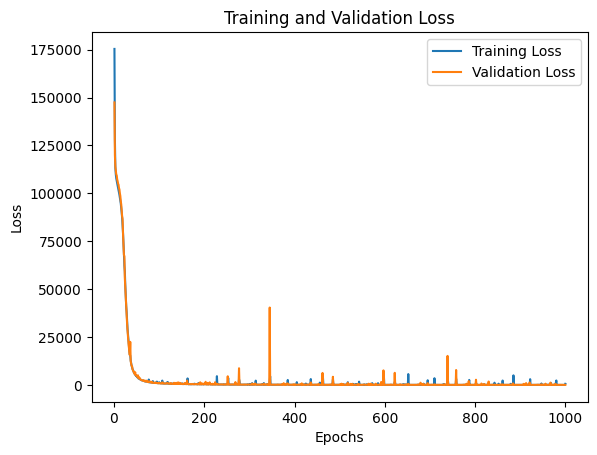

(586.2846372951932, 46.19793382432726)

In [128]:
mlp.trainer()

In [142]:
mlp.tester(Xtr,Ytr)

Test Loss: 6.113522


6.113521500311958

In [27]:
learning_rate = 1e-4
hidden_size = 32
num_layers = 2
embedding_size=16
model = RNNModel(input_size=13, hidden_size=hidden_size, num_layers=num_layers, output_size=1,embedding_size=embedding_size).to(device)

In [28]:
rnn=HelperClass(Xtr,Ytr,model,700,1e-4)

Epoch [1/700], Train Loss: 221493.3460, Val Loss: 223252.2124
Epoch [2/700], Train Loss: 221413.1234, Val Loss: 223115.9306
Epoch [3/700], Train Loss: 221020.6350, Val Loss: 222075.5210
Epoch [4/700], Train Loss: 215493.1789, Val Loss: 204848.5256
Epoch [5/700], Train Loss: 189426.0091, Val Loss: 179437.5590
Epoch [6/700], Train Loss: 169027.8488, Val Loss: 159131.2914
Epoch [7/700], Train Loss: 153937.2787, Val Loss: 147772.6387
Epoch [8/700], Train Loss: 145050.8614, Val Loss: 140228.9461
Epoch [9/700], Train Loss: 138429.5819, Val Loss: 134220.6450
Epoch [10/700], Train Loss: 132908.4528, Val Loss: 129061.2911
Epoch [11/700], Train Loss: 127846.4170, Val Loss: 124157.3218
Epoch [12/700], Train Loss: 122932.1140, Val Loss: 119187.7784
Epoch [13/700], Train Loss: 117910.0483, Val Loss: 114190.7513
Epoch [14/700], Train Loss: 112689.8497, Val Loss: 108988.2426
Epoch [15/700], Train Loss: 107267.4661, Val Loss: 103471.7440
Epoch [16/700], Train Loss: 101695.3246, Val Loss: 98344.9313
Ep

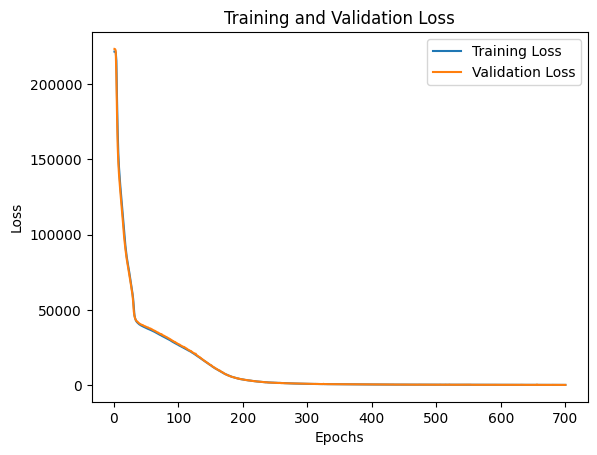

314.6250351019965

In [29]:
rnn.trainer()

In [141]:
rnn.tester(Xte,Yte)

Test Loss: 9.874339


9.874338655090332